# Project 2 Notebook

Imported necessary libraries

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score

## Defining Functions 

Created functions for the model assessments

In [2]:
def sm_metrics(model, y, X):
    # import associated tools
    from statsmodels.tools.eval_measures import rmse, mse, meanabs
    
    # now generate predictions
    ypred = model.predict(X)

    # Print values
    print('Metrics:')
    # MAE
    print(f"Mean Absolute Error: {meanabs(y, ypred):.3f}")
    # MSE
    print(f"Mean Squared Error: {mse(y, ypred):.3f}")
    # RMSE
    print(f"Root Mean Squared Error: {rmse(y, ypred):.3f}")
    return

In [3]:
def qq(x_test, x_train, y_test, y_train):
    # QQ plots are generally great tools for checking for normality.
    import statsmodels.api as sm
    from sklearn.linear_model import LinearRegression
    
    # Calculating residuals
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_hat = lr.predict(x_test)
    
    residuals = y_test - y_hat
    
    
    sm.qqplot(residuals, line = 'r');
    return

In [4]:
# evaluates the Variance Inflation Factor of X_train variables

def vif(X_train):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # defining an empty dataframe to capture the VIF scores
    vif = pd.DataFrame()

    # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

    # label the scores with their related columns
    vif["features"] = X_train.columns
    
    # print out the vif table and return
    print(vif)
    return

Loaded in the kc_house_data.csv using pandas library

In [5]:
housedf = pd.read_csv('data/kc_house_data.csv')


In [6]:
housedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
housedf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [8]:
housedf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Created a few dataframes for different use cases:
- **dfinit**: used to drop columns that we were not utilizing in our model/data analysis (mostly categorical columns)
- **dfrev1**: used to drop numerical columns
- **dfrevcopy**: used for testing some modeling so that I didn't have to re-run everything when I made a mistake

Also added some features to the original housedf:
- **sqft_per_bedroom**: the sqft_living divided by bedrooms value for avg sqft per bedroom
- **footprint**: the sqft_living divided by sqft_lot for relative sqft of usage

In [9]:
dfinit = housedf.drop(['id', 'date', 'yr_renovated', 'condition', 'waterfront', 'lat', 'long', 
                 'sqft_above', 'sqft_basement', 'view'], axis=1).copy()

dfrev1 = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
dfrevcopy = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
housedf['sqft_per_bedroom'] = housedf['sqft_living'] / housedf['bedrooms']
housedf['footprint'] = housedf['sqft_living'] / housedf['sqft_lot']
housedf

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,393.333333,0.208850
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,856.666667,0.354874
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,385.000000,0.077000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,490.000000,0.392000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,560.000000,0.207921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,510.000000,1.352785
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,577.500000,0.397385
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,510.000000,0.755556
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,533.333333,0.670017


# Correlation and Heatmap Visualization

Visualized correlation between variables using .corr() method, then plotted the correlation out for easier visualization on
the sns.heatmap

In [10]:
housedf.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.011922,0.088238
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,0.580109,0.123063
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.024076,0.026798
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,0.517415,0.287015
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,0.755398,0.076988
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.190583,-0.252601
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.290654,0.556700
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077,0.671149,0.051612
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777,0.257801,0.279053
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852,0.063348,-0.001743


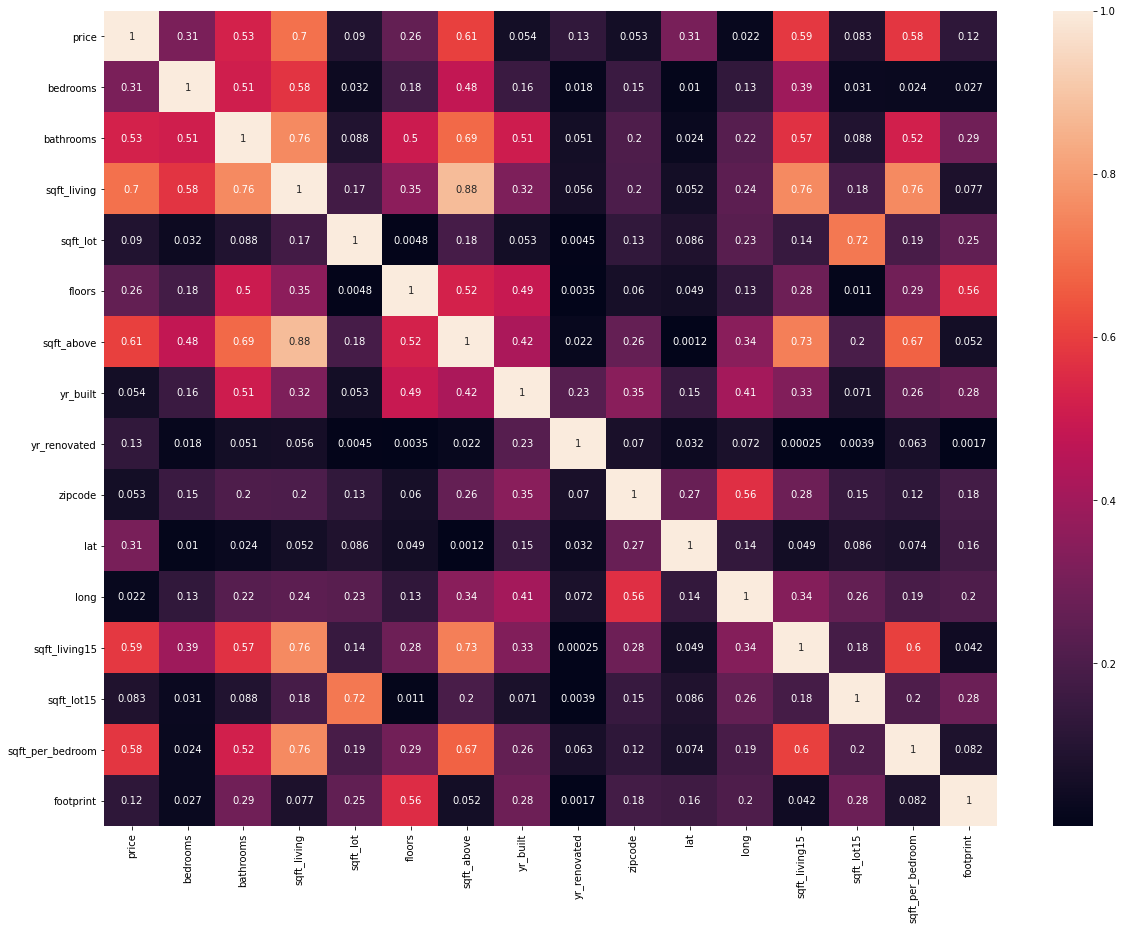

In [11]:
plt.figure(figsize = (20,15))
sns.heatmap(housedf.drop(['id'], axis =1).corr().abs(), annot=True);

# Model Creation and Application

Created training and test datasets for the housedf dataframe. Utilized a 80 / 20 split.

In [12]:
y = housedf['price']
X = housedf[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode', 'sqft_per_bedroom', 'footprint']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

## Dummy Regressor

Created a Dummy Regressor on the mean for use as our baseline model. 
- We used the predict function and saw that it printed out an array filled with the same values
- We then checked the score to see that it gave us a 0 value, so we know that this is the baseline we will compare our other models to.

In [13]:
#Dummy Regressor

basemodel = DummyRegressor(strategy = 'mean')
basemodel.fit(X_train,y_train)
basemodel.predict(X_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

In [14]:
basemodel.score(X_train,y_train)

0.0

## StandardScaler and OneHotEncoder

Created a StandardScalar for our dataset because we had data values such as 1 bedroom vs. thousands of sqft

In [15]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

Created a OneHotEncoder for our initial model 

In [16]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train)

<17277x26530 sparse matrix of type '<class 'numpy.float64'>'
	with 155493 stored elements in Compressed Sparse Row format>

Created a training data sat based on the StandardScalar values and our training/test split

In [17]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X.columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled, y_train), axis=1)
X_train.reset_index(drop=True, inplace=True)
X_train_final = pd.concat((X_train, y_train), axis=1)

In [18]:
X_train_scaled

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint
0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192,0.882599,-0.484799,-0.470293
1,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897,-1.105526,0.066728,-0.540972
2,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307,-0.824188,-0.083688,-0.202228
3,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770,0.507481,0.217145,1.490978
4,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379,1.857905,1.802302,0.259627
...,...,...,...,...,...,...,...,...,...
17272,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180,1.032646,0.934515,1.519793
17273,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529,-0.073952,0.184747,0.701581
17274,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939,-1.199306,2.862930,-0.846551
17275,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325,-0.374046,-1.090321,-0.554328


Created the test dataset based on our StandardScalar values and our training/test split

In [19]:
#Test 
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X.columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

In [20]:
X_test_scaled_final

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint,price
0,0.670108,0.505427,-0.340624,-0.242455,0.937801,1.123192,-0.749164,-0.812629,0.112411,291500.0
1,-0.404166,-1.455485,-0.985109,-0.242407,0.010148,-0.851253,1.445276,-1.040182,-0.327116,220000.0
2,0.670108,0.505427,0.729878,-0.247290,0.937801,-2.246981,0.469969,0.321279,0.927181,1030000.0
3,0.670108,0.505427,0.249245,-0.229740,0.937801,1.089150,-0.073952,-0.187823,0.350697,651100.0
4,-0.404166,-0.148210,-0.613711,-0.241488,0.937801,0.204054,1.857905,-0.515653,-0.082660,434900.0
...,...,...,...,...,...,...,...,...,...,...
4315,0.670108,0.505427,0.434944,0.032147,-0.917505,-0.408705,-0.936723,0.008876,-0.640927,560000.0
4316,-0.404166,0.505427,-0.646481,-0.303419,2.793107,1.293403,1.032646,-0.561935,1.032786,348000.0
4317,0.670108,0.505427,0.107239,-0.189203,0.937801,0.612560,-0.355291,-0.338239,-0.078699,464000.0
4318,1.744382,1.159065,1.680222,-0.054440,-0.917505,-0.238494,-1.349353,0.490208,-0.150724,858000.0


## First Model

Created our first model based on the values in our heatmap that had the highest correlation with price, in this case that was the sqft_living + bedrooms + floors columns

In [21]:
# Keep first model as sqft_living + bedrooms + floors to show that was our first model and how we progressed
# 2nd model should be 'price ~ sqft_living + bedrooms + sqft_per_bedroom + footprint' to show the increase of R^2
formula = 'price ~  sqft_living + bedrooms + floors'
model = ols(formula, X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5874.
Date:                Tue, 15 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:19:02   Log-Likelihood:            -2.3986e+05
No. Observations:               17277   AIC:                         4.797e+05
Df Residuals:                   17273   BIC:                         4.798e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.409e+05   1970.511    274.521      0.000    5.37e+05    5.45e+05
sqft_living  2.882e+05   2530.414    113.894      0.000    2.83e+05    2.93e+05
bedrooms    -5.411e+04   2402.875    -22.520      0.000   -5.88e+04   -4.94e+04
floors       1412.8026   2110.123      0.670      0.503   -2723.252    5548.857
==============================================================================
Omnibus:                    11809.269   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           435749.399
Skew:                           2.803   Prob(JB):                         0.00
Kurtosis:                      26.956   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Called the functions we defined earlier to find the metrics of our model. We prioritize/focus on RMSE because it provides us with more accuracy.

In [22]:
sm_metrics(model, y_test, X_test_scaled)

Metrics:
Mean Absolute Error: 169584.127
Mean Squared Error: 64475389966.508
Root Mean Squared Error: 253920.046


We then fit a LinearRegression model on our training data set

In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_hat = lr.predict(X_train_scaled)

We calculate the residuals

In [24]:
# y_pred = model.predict(X_test)
residuals = (y_train - y_hat)
#print(type(y_pred))
#print(type(y_test))
print(residuals)

0        275367.710636
1       -115599.954233
2        -18086.347609
3        -78046.221284
4       -430959.892978
             ...      
17272   -127309.451047
17273     32821.092697
17274    -63103.059987
17275    -25743.519373
17276     40167.158771
Name: price, Length: 17277, dtype: float64


Then we plot on a qqplot to visualize the residuals and see where our error lies

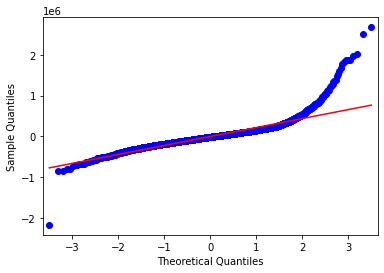

In [25]:
qq(X_test_scaled, X_train_scaled, y_test, y_train)

In [26]:
X_train_scaled.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint
bedrooms,1.000000,0.509423,0.571636,0.026344,0.178529,0.154396,-0.152053,-0.024644,0.030371
bathrooms,0.509423,1.000000,0.752564,0.085556,0.503355,0.511066,-0.205060,0.517643,0.289180
sqft_living,0.571636,0.752564,1.000000,0.170260,0.356378,0.320881,-0.201041,0.759121,0.077961
sqft_lot,0.026344,0.085556,0.170260,1.000000,-0.001869,0.053034,-0.128976,0.194870,-0.250546
floors,0.178529,0.503355,0.356378,-0.001869,1.000000,0.488497,-0.058795,0.293768,0.553484
yr_built,0.154396,0.511066,0.320881,0.053034,0.488497,1.000000,-0.347291,0.261316,0.279235
zipcode,-0.152053,-0.205060,-0.201041,-0.128976,-0.058795,-0.347291,1.000000,-0.124074,0.177918
sqft_per_bedroom,-0.024644,0.517643,0.759121,0.194870,0.293768,0.261316,-0.124074,1.000000,0.080342
footprint,0.030371,0.289180,0.077961,-0.250546,0.553484,0.279235,0.177918,0.080342,1.000000


We then check the VIF to see if we missed anything about multicollinearity between the variables.

In [27]:
vif(X_train_scaled)

         VIF          features
0   5.717885          bedrooms
1   3.231989         bathrooms
2  14.643617       sqft_living
3   1.139986          sqft_lot
4   1.949245            floors
5   1.730710          yr_built
6   1.273374           zipcode
7   9.032754  sqft_per_bedroom
8   1.764374         footprint


We now run the second model to see

In [28]:
formula = 'price ~  sqft_living + bedrooms + sqft_per_bedroom + footprint'
model = ols(formula, X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     4538.
Date:                Tue, 15 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:19:03   Log-Likelihood:            -2.3973e+05
No. Observations:               17277   AIC:                         4.795e+05
Df Residuals:                   17272   BIC:                         4.795e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.409e+05   1955.771    276.590      0.000    5.37e+05    5.45e+05
sqft_living       3.557e+05   7140.870     49.815      0.000    3.42e+05     3.7e+05
bedrooms         -9.471e+04   4650.617    -20.365      0.000   -1.04e+05   -8.56e+04
sqft_per_bedroom -6.031e+04   5864.235    -10.284      0.000   -7.18e+04   -4.88e+04
footprint         2.529e+04   1963.209     12.880      0.000    2.14e+04    2.91e+04
==============================================================================
Omnibus:                    11801.341   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           420835.975
Skew:                           2.813   Prob(JB):                         0.00
Kurtosis:                      26.515   Cond. No.                         7.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We then see that our R^2 value increases and we check our RMSE to see if the values make sense to us.

In [48]:
sm_metrics(model, y_test, X_test_scaled)

Metrics:
Mean Absolute Error: 166751.568
Mean Squared Error: 63499884464.314
Root Mean Squared Error: 251991.834


## Checking to see if we should add our demographic data to our models

We load in the demographic XLS file from which we pulled this list of unique Zipcode values that we defined as kc_zips.

In [29]:
kc_zips = [98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198,
           98146, 98038, 98007, 98115, 98107, 98126, 98019, 98103, 
           98002, 98133, 98040, 98092, 98030, 98119, 98112, 98052, 
           98027, 98117, 98058, 98001, 98056, 98166, 98023, 98070, 
           98148, 98105, 98042, 98008, 98059, 98122, 98144, 98004, 
           98005, 98034, 98075, 98116, 98010, 98118, 98199, 98032, 
           98045, 98102, 98077, 98108, 98168, 98177, 98065, 98029, 
           98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031, 
           98106, 98072, 98188, 98014, 98055, 98039]

In [30]:
df2 = pd.read_excel('data/demographic_spatial_join.xls')

b_series = df2.ZCTA5CE10.isin(kc_zips)
df_zips = df2[b_series]

df_names = df_zips[['ZCTA5CE10', 'NAME']]
df_names.head()


,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest


In [31]:
df_names.NAME.value_counts()

Northeast    33
West         29
Southeast    26
Southwest    17
Shoreline    12
Name: NAME, dtype: int64

In [32]:
df_names

,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest
...,...,...
138,98188,Southeast
139,98188,Southwest
141,98198,Southeast
142,98198,Southwest


In [33]:
# Dropping duplicates randomly, for the moment
df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)
df_names.ZCTA5CE10

<ipython-input-33-af7d0a158eea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)


0      98001
2      98002
3      98003
5      98004
6      98005
       ...  
131    98177
135    98178
138    98188
141    98198
143    98199
Name: ZCTA5CE10, Length: 70, dtype: int64

In [34]:
# lists of zipcodes
northeast = df_names.query('NAME=="Northeast"')['ZCTA5CE10'].to_list()
west = df_names.query('NAME=="West"')['ZCTA5CE10'].to_list()
shoreline = df_names.query('NAME=="Shoreline"')['ZCTA5CE10'].to_list()
southwest = df_names.query('NAME=="Southwest"')['ZCTA5CE10'].to_list()
southeast = df_names.query('NAME=="Southeast"')['ZCTA5CE10'].to_list()
print("Northeast: ", northeast)
print("Shoreline: ", shoreline)

Northeast:  [98004, 98005, 98006, 98007, 98008, 98011, 98014, 98019, 98024, 98027, 98028, 98029, 98033, 98034, 98038, 98039, 98040, 98045, 98052, 98053, 98056, 98059, 98065, 98072, 98074, 98075, 98077]
Shoreline:  [98125, 98133, 98155, 98177]


In [35]:
# Create new  DF for revisions, change type
dfrev2 = dfrev1.copy()
#dfrev2 = dfrev2.astype({"zipcode": str})
# use lists to make categorical bins
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=northeast, value = "Northeast")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=west, value = "West")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=shoreline, value = "Shoreline")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southwest, value = "Southwest")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southeast, value = "Southeast")

dfrev2.zipcode.value_counts()

Northeast    8560
West         4442
Southeast    4126
Southwest    2866
Shoreline    1603
Name: zipcode, dtype: int64

In [36]:
dfrevcopy['grade'].value_counts()


7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

## Training/Test split to see if these new predictors are relevant to our model

We then created a new training/test split to see if we should add these predictors to our model or not. We did not want to affect our original model so we created a new test model to see the effect of adding another categorical column 'grade' to our dataframe.

In [37]:
y1 = dfrev2['price']
X1 = dfrev2[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode','grade']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=56)

Created DummyRegressor similar to how we did it for our first model.

In [38]:
#Dummy Regressor

basemodel1 = DummyRegressor(strategy = 'mean')
basemodel1.fit(X1_train, y1_train)
basemodel1.predict(X1_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

Dropped the numerical columns from our dataframe so that we could only focus on and OneHotEncode the categorical values we pulled from our demographics XLS

In [39]:
ohe1 = OneHotEncoder(drop = 'first')
grade_transform = ohe1.fit_transform(X1_train.drop(['bedrooms','bathrooms','sqft_living','sqft_lot','yr_built'], axis = 1))

Checked to see if we did the OHE correctly

In [40]:
column_names = ohe1.get_feature_names()

In [41]:
len(column_names)

18

In [42]:
pd.get_dummies(X1_train)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,...,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
8192,3,2.00,1540,7800,1.0,2004,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
18780,4,2.75,2530,14178,2.0,1997,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4957,3,2.25,1800,6680,2.0,1983,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1168,4,2.50,2660,3672,2.0,1910,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15335,4,2.75,4030,10240,2.0,1943,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9338,2,2.25,1640,2240,2.0,1980,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
13730,5,3.25,3290,6422,2.0,2012,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3264,3,3.25,3710,38509,2.0,1998,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
399,4,1.75,1530,8750,1.5,1968,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Created a dataframe with the new OHE values for our categorical columns from housedf, ad we added the price column from our original dataframe to the OHE dataframe to check for correlation between these variables and if they had an effect on home pricing.

In [43]:
dfrev3 = pd.DataFrame(grade_transform.todense(), columns=ohe1.get_feature_names())
dfrev3.head()

,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,x1_Shoreline,x1_Southeast,x1_Southwest,x1_West,x2_11 Excellent,x2_12 Luxury,x2_13 Mansion,x2_4 Low,x2_5 Fair,x2_6 Low Average,x2_7 Average,x2_8 Good,x2_9 Better
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
dfrev3['price'] = dfrev2['price']

In [45]:
dfrev3.corr()

,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,x1_Shoreline,x1_Southeast,x1_Southwest,x1_West,x2_11 Excellent,x2_12 Luxury,x2_13 Mansion,x2_4 Low,x2_5 Fair,x2_6 Low Average,x2_7 Average,x2_8 Good,x2_9 Better,price
x0_1.5,1.000000,-0.244638,-0.027479,-0.052485,-0.005793,0.002665,-0.047916,0.022100,0.212288,-0.031011,-0.019681,-0.007845,-0.000626,0.024247,0.061949,0.079705,-0.053611,-0.061178,-0.003325
x0_2.0,-0.244638,1.000000,-0.069588,-0.132912,-0.014670,-0.134179,-0.025883,-0.108511,-0.096946,0.122443,0.052127,0.013183,-0.029356,-0.081632,-0.233467,-0.290405,0.147202,0.272373,0.003823
x0_2.5,-0.027479,-0.069588,1.000000,-0.014930,-0.001648,-0.014904,-0.027539,-0.022950,0.080418,0.050892,0.015324,0.050082,-0.003297,-0.009298,-0.023704,-0.061579,0.013974,0.036483,-0.005008
x0_3.0,-0.052485,-0.132912,-0.014930,1.000000,-0.003147,0.049256,-0.077959,-0.049492,0.220447,0.007757,-0.005103,-0.004262,-0.006298,-0.017759,-0.053966,-0.083843,0.124852,0.012636,0.000354
x0_3.5,-0.005793,-0.014670,-0.001648,-0.003147,1.000000,-0.005268,-0.009002,0.001854,0.028867,-0.002581,0.048074,-0.000470,-0.000695,-0.001960,-0.005957,-0.015802,0.022984,-0.006875,-0.004323
x1_Shoreline,0.002665,-0.134179,-0.014904,0.049256,-0.005268,1.000000,-0.136507,-0.110646,-0.144162,-0.037506,-0.007378,0.019168,-0.010541,-0.014841,0.040858,0.067950,-0.013586,-0.060654,-0.012151
x1_Southeast,-0.047916,-0.025883,-0.027539,-0.077959,-0.009002,-0.136507,1.000000,-0.189083,-0.246360,-0.054909,-0.028241,-0.012191,0.013731,0.021668,0.028627,0.100784,-0.026789,-0.066623,-0.008643
x1_Southwest,0.022100,-0.108511,-0.022950,-0.049492,0.001854,-0.110646,-0.189083,1.000000,-0.199686,-0.041655,-0.016679,-0.009881,0.008289,0.039150,0.214182,0.020687,-0.065107,-0.077702,-0.005714
x1_West,0.212288,-0.096946,0.080418,0.220447,0.028867,-0.144162,-0.246360,-0.199686,1.000000,-0.029576,-0.018695,-0.001537,-0.015185,-0.020650,-0.037254,0.033725,0.036626,-0.022535,0.000227
x2_11 Excellent,-0.031011,0.122443,0.050892,0.007757,-0.002581,-0.037506,-0.054909,-0.041655,-0.029576,1.000000,-0.008768,-0.003495,-0.005164,-0.014562,-0.044250,-0.117388,-0.086302,-0.051071,0.003529


In [46]:
df_corrs = dfrev3.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs

price               1.000000
x1_Shoreline        0.012151
x1_Southeast        0.008643
x2_4 Low            0.008474
x2_6 Low Average    0.005719
x1_Southwest        0.005714
x0_2.5              0.005008
x0_3.5              0.004323
x2_12 Luxury        0.004233
x0_2.0              0.003823
x2_11 Excellent     0.003529
x0_1.5              0.003325
x2_13 Mansion       0.002502
x2_9 Better         0.002145
x2_7 Average        0.001758
x2_5 Fair           0.000743
x2_8 Good           0.000586
x0_3.0              0.000354
x1_West             0.000227
Name: price, dtype: float64

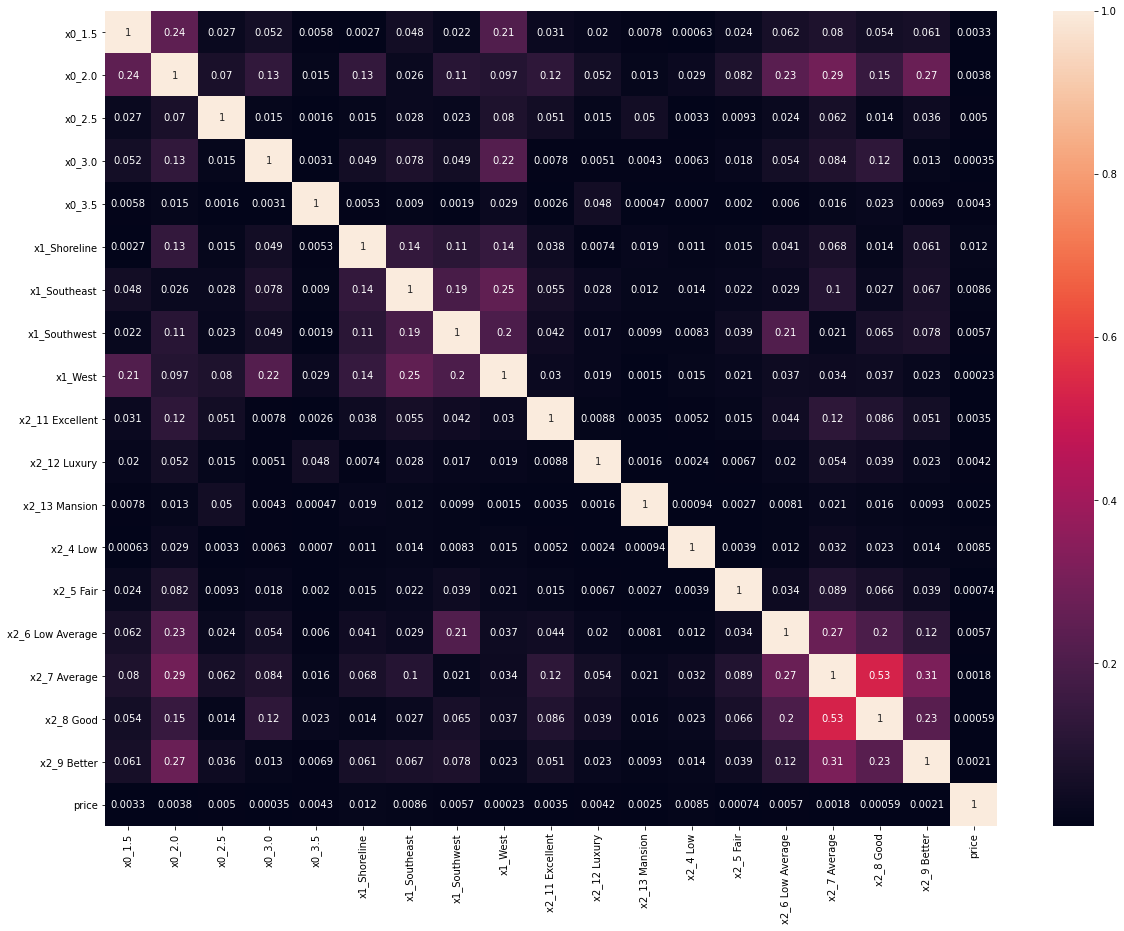

In [47]:
plt.figure(figsize = (20, 15))
sns.heatmap(dfrev3.corr().abs(), annot=True);

As we can see from the df_corrs and the heatmap generated above, there is little to no correlation between the categorical variables we identified (grade/zipcode/floors) and their effect on price.